In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy as sp
import statistics
from sklearn import set_config
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             median_absolute_error,
                             max_error, make_scorer
                            )
from sklearn.metrics import PredictionErrorDisplay
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score,validation_curve,learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset,linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/home/cathu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Metriques de performances

In [3]:
def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])


def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [4]:
METRICS = [r2_score,
           mean_squared_error,
           median_absolute_error,
           max_error
          ]

In [5]:
def rmse(x,y):
    rmse= np.sqrt(mean_squared_error(x,y))
    return rmse

### Pipeline de modélisation

In [6]:
def model(estimateur,normaliseur):
    model = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("regressor", estimateur)]
    )

    return model

In [7]:
base_f=pd.read_csv('base_finale.csv')

In [123]:
base_f.sample(10)

CODGEO  SUPERF       P20_RP  MED20 TP6020    P20_EMPLT  ETOQ21  \
936   91666    5.36   948.000000  28250      s  1355.693525     8.0   
962   77520   12.25   305.296633  27640      s    71.557065     4.0   
885   77475   10.97  1998.926731  24640    8,0  1098.467742    15.0   
425   77182   17.32  2057.712117  18730   23,0  1902.187373    22.0   
383   78310   10.39  1735.509545  23910    9,0  2547.783900    18.0   
212   77098    3.40   140.750246  24510      s    17.778690     1.0   
275   77156    7.83   375.030053  24040      s   304.127878     2.0   
559   78382    3.65  1713.982637  28680    8,0   497.361995     7.0   
336   78265   10.69  1048.488735  30330      s   345.227483     5.0   
287   95210    1.77  5331.090226  30380   10,0  4951.755333    72.0   

                nom_com  insee_com  longueur  longueur_pond_hw  \
936           Villejust      91666     11760          12413.25   
962  Villiers-sous-Grez      77520      5889           5273.25   
885            Trilport      77475      8212           7894.50   
425    La Ferté-Gaucher      77182      1758           1960.75   
383              Houdan      78310      8072           7679.00   
212        Châteaubleau      77098       181            181.00   
275            Darvault      77156       378            453.25   
559          Maurecourt      78382      6332           6651.00   
336         Garancières      78265      5378           4915.75   
287   Enghien-les-Bains      95210      8143           6785.50   

     longueur_pond_adg  difference_hw  difference_adg  cap_com  stat_com  \
936           13240.50         653.25         1480.50      NaN       NaN   
962            6044.75        -615.75          155.75      NaN       NaN   
885            8309.50        -317.50           97.50      NaN       NaN   
425            2087.75         202.75          329.75      NaN       NaN   
383            8545.00        -393.00          473.00      NaN       NaN   
212              90.50           0.00          -90.50      NaN       NaN   
275             453.25          75.25           75.25      NaN       NaN   
559            6783.00         319.00          451.00      NaN       NaN   
336            5243.50        -462.25         -134.50      NaN       NaN   
287            8477.25       -1357.50          334.25      NaN       NaN   

                               source       surface  population  \
936  IGN:EXPRESS-COG-CARTO-TERRITOIRE  5.363387e+06        2425   
962  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.214375e+07         646   
885  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.096045e+07        5045   
425  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.737603e+07        4933   
383  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.041617e+07        3671   
212  IGN:EXPRESS-COG-CARTO-TERRITOIRE  3.385862e+06         358   
275  IGN:EXPRESS-COG-CARTO-TERRITOIRE  7.819727e+06         896   
559  IGN:EXPRESS-COG-CARTO-TERRITOIRE  3.690160e+06        4414   
336  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.040980e+07        2375   
287  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.750133e+06       11470   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [8]:
base_f.describe()

,CODGEO,SUPERF,P20_RP,P20_EMPLT,ETOQ21,insee_com,longueur,longueur_pond_hw,longueur_pond_adg,difference_hw,difference_adg,cap_com,stat_com,surface,population,dep,com,mort_com,hosp_com,indemne_com,leger_com,acc_com
count,1005.000000,985.000000,985.000000,985.000000,985.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,82.000000,82.000000,1.005000e+03,1005.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,84832.089552,8.984548,4161.244593,3998.114104,30.808122,84832.089552,14104.276617,13958.353731,14310.651244,-145.922886,206.374627,556.780488,17.951220,8.955252e+06,12040.500498,85.299094,85559.551360,0.416918,2.799094,26.185801,26.706949,56.232628
std,7930.037655,8.141997,7227.416028,9815.728109,55.740130,7930.037655,24139.660522,23629.009724,23513.063958,1425.025097,2915.169853,713.441408,21.245713,8.147897e+06,23891.323510,7.988151,7971.299142,0.790383,4.484682,60.449628,60.573746,125.325972
min,75101.000000,0.090000,21.200000,3.355556,0.000000,75101.000000,2.000000,2.500000,2.500000,-12902.000000,-22854.000000,0.000000,1.000000,9.722876e+04,50.000000,75.000000,75101.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,77423.000000,4.560000,320.138431,118.691477,3.000000,77423.000000,1476.000000,1466.250000,1643.250000,-273.500000,0.000000,120.500000,4.000000,4.481700e+06,850.000000,77.000000,77435.500000,0.000000,0.000000,1.000000,1.000000,3.000000
50%,78550.000000,7.360000,988.199937,599.673560,8.000000,78550.000000,5293.000000,5337.000000,5725.000000,-8.750000,155.000000,236.000000,8.000000,7.343944e+06,2699.000000,91.000000,91046.000000,0.000000,1.000000,4.000000,4.000000,10.000000
75%,93027.000000,11.330000,4403.753165,3451.263639,32.000000,93027.000000,15626.000000,15930.250000,16379.250000,165.500000,870.500000,709.000000,22.750000,1.135592e+07,12266.000000,93.000000,93061.750000,1.000000,3.000000,21.000000,22.000000,46.000000
max,95690.000000,172.050000,59417.772923,100483.060628,502.000000,95690.000000,228240.000000,226273.250000,231651.000000,15562.250000,20850.500000,3345.000000,90.000000,1.722864e+08,230981.000000,95.000000,95690.000000,5.000000,43.000000,606.000000,594.000000,1247.000000


In [9]:
base_f.shape

(1005, 27)

In [10]:
base_f.columns

Index(['CODGEO', 'SUPERF', 'P20_RP', 'MED20', 'TP6020', 'P20_EMPLT', 'ETOQ21',
       'nom_com', 'insee_com', 'longueur', 'longueur_pond_hw',
       'longueur_pond_adg', 'difference_hw', 'difference_adg', 'cap_com',
       'stat_com', 'source', 'surface', 'population', 'geometry', 'dep', 'com',
       'mort_com', 'hosp_com', 'indemne_com', 'leger_com', 'acc_com'],
      dtype='object')

Les variables CODGEO, nom_com, insee_com, difference_hw, 'TP6020, difference_adg, dep, com, mort_com, hosp_com, indemne_com, leger_com, source et geometry ne seront pas utilisées pour la modélisation

In [156]:
#base= base_f[['longueur', 'longueur_pond_hw','longueur_pond_adg','SUPERF', 'P20_RP','MED20', 'P20_EMPLT', 'ETOQ21', 'cap_com','stat_com', 'surface', 'population']]

In [11]:
base= base_f[['longueur', 'longueur_pond_hw','longueur_pond_adg','SUPERF', 'P20_RP','MED20', 'P20_EMPLT', 'ETOQ21','surface', 'population', 'acc_com']]

In [12]:
base.describe()

,longueur,longueur_pond_hw,longueur_pond_adg,SUPERF,P20_RP,P20_EMPLT,ETOQ21,surface,population,acc_com
count,1005.000000,1005.000000,1005.000000,985.000000,985.000000,985.000000,985.000000,1.005000e+03,1005.000000,662.000000
mean,14104.276617,13958.353731,14310.651244,8.984548,4161.244593,3998.114104,30.808122,8.955252e+06,12040.500498,56.232628
std,24139.660522,23629.009724,23513.063958,8.141997,7227.416028,9815.728109,55.740130,8.147897e+06,23891.323510,125.325972
min,2.000000,2.500000,2.500000,0.090000,21.200000,3.355556,0.000000,9.722876e+04,50.000000,1.000000
25%,1476.000000,1466.250000,1643.250000,4.560000,320.138431,118.691477,3.000000,4.481700e+06,850.000000,3.000000
50%,5293.000000,5337.000000,5725.000000,7.360000,988.199937,599.673560,8.000000,7.343944e+06,2699.000000,10.000000
75%,15626.000000,15930.250000,16379.250000,11.330000,4403.753165,3451.263639,32.000000,1.135592e+07,12266.000000,46.000000
max,228240.000000,226273.250000,231651.000000,172.050000,59417.772923,100483.060628,502.000000,1.722864e+08,230981.000000,1247.000000


Les stations vélib ne sont pas présentes dans toutes les communes équipées d'une piste cyclables, ce qui justifie la présence de valeurs manquantes pour les variables cap_com et stat_com. Etant en présence de variables numériques positives, ces valeurs manquantes seront imputées par 0. 

In [13]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   longueur           1005 non-null   int64  
 1   longueur_pond_hw   1005 non-null   float64
 2   longueur_pond_adg  1005 non-null   float64
 3   SUPERF             985 non-null    float64
 4   P20_RP             985 non-null    float64
 5   MED20              985 non-null    object 
 6   P20_EMPLT          985 non-null    float64
 7   ETOQ21             985 non-null    float64
 8   surface            1005 non-null   float64
 9   population         1005 non-null   int64  
 10  acc_com            662 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 86.5+ KB


In [14]:
base['MED20'] = pd.to_numeric(base['MED20'], errors='coerce').astype(float)

/tmp/ipykernel_165044/3105187580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['MED20'] = pd.to_numeric(base['MED20'], errors='coerce').astype(float)


In [15]:
base.fillna(0, inplace=True)

/tmp/ipykernel_165044/84762160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.fillna(0, inplace=True)


In [16]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   longueur           1005 non-null   int64  
 1   longueur_pond_hw   1005 non-null   float64
 2   longueur_pond_adg  1005 non-null   float64
 3   SUPERF             1005 non-null   float64
 4   P20_RP             1005 non-null   float64
 5   MED20              1005 non-null   float64
 6   P20_EMPLT          1005 non-null   float64
 7   ETOQ21             1005 non-null   float64
 8   surface            1005 non-null   float64
 9   population         1005 non-null   int64  
 10  acc_com            1005 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 86.5 KB


In [17]:
base['log_long']= np.log(base['longueur'])
base['log_lph']=np.log(base['longueur_pond_hw'])
base['log_lpadg']=np.log(base['longueur_pond_adg'])

/tmp/ipykernel_165044/996073743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_long']= np.log(base['longueur'])
/tmp/ipykernel_165044/996073743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_lph']=np.log(base['longueur_pond_hw'])
/tmp/ipykernel_165044/996073743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

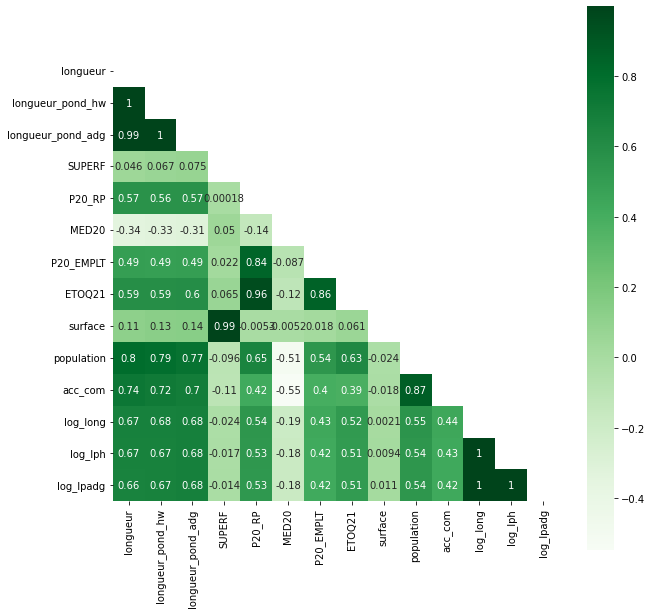

In [18]:
plt.figure(figsize=(10, 10))
corr= base.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(base.corr(), cmap='Greens',square=True, mask=mask, cbar=True, annot=True);

L'examen du tableau de corrélation révèle une corrélation très significative entre les variables longueur, longueur_pond_hw et longueur_pond_adg, indiquant qu'elles représentent essentiellement la même information. De plus, les analyses descriptives effectuées dans la partie 2 montrent une distribution sensiblement identique de ces variables, nous gardons donc comme variable d'intérêt uniquement la vriable longueur. 

De manière similaire, les variables surface et superficie (SUPERF) présentent une corrélation élevée, suggérant une redondance dans l'information qu'elles portent. Par conséquent, afin de simplifier la modélisation, nous choisirons de retenir uniquement l'une des variables de chaque paire fortement corrélée.

### Modélisation linéaire de la longueur

In [19]:
Y= base['longueur']

In [20]:
base.columns

Index(['longueur', 'longueur_pond_hw', 'longueur_pond_adg', 'SUPERF', 'P20_RP',
       'MED20', 'P20_EMPLT', 'ETOQ21', 'surface', 'population', 'acc_com',
       'log_long', 'log_lph', 'log_lpadg'],
      dtype='object')

#### Régression linéaire

In [21]:
reg_lin=sm.OLS(Y, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population', 'acc_com']])).fit()

In [22]:
print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               longueur   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     383.1
Date:                Sat, 30 Dec 2023   Prob (F-statistic):          6.57e-255
Time:                        23:47:02   Log-Likelihood:                -10967.
No. Observations:                1005   AIC:                         2.195e+04
Df Residuals:                     998   BIC:                         2.198e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9229.9478   2430.118     -3.798      0.0

Les résultats de la régression de la longueur des aménagements cyclables indiquent que le modèle dans son ensemble est statistiquement significatif, avec une probabilité associée au F-statistic très proche de zéro (Prob (F-statistic) = 2.47e-241). De plus, le modèle présente un pouvoir prédictif considérable, atteignant plus de 67%. Au seuil de 10%, toutes les variables sont statistiquement significatives.
A l'exception de la variable P20_EMPLT, les effets marginaux des autres variables sont tous positifs. Cela signifie que, toutes choses étant égales par ailleurs, une augmentation d'une unité dans ces variables est associée à une augmentation positive de la longueur des aménagements cyclables. En particulier, une augmentation d'une personne dans la population est associée à une augmentation de 0.79 mètres de la longueur des aménagements cyclables.

Cependant, bien que ce modèle semble approprié, sa validation requiert la réalisation d'une série de tests supplémentaires pour garantir sa robustesse et sa fiabilité. Ces tests pourraient inclure des vérifications de l'hétéroscédasticité, de l'autocorrélation des résidus, et d'autres diagnostics pour s'assurer que les hypothèses du modèle sont satisfaites.

Pour la suite des analyses nous utiliserons le seuil de 10%.

#### Vérification des hypothèses de la régréssion linéaire

In [25]:
# Normalité des résidus 
residus= reg_lin.resid
sw_test = shapiro(residus)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.7690492272377014, pvalue=2.452188261565501e-35)


Les hypothèses du  test de Shapiro-Wilk utilisé sont :
    - 
H0 (hypothèse nulle) : Les données suivent une distribution normale    - .
H1 (hypothèse alternative) : Les données ne suivent pas une distribution normale.
La valeur de la p-value obtenue à partir du test de Shapiro-Wilk est utilisée pour prendre une décision statistiq
ue. Si la p-value est inférieure à un seuil de signification prédéf, 10% dans notre cas.05), on rejette l'hypothèse nulle en faveur de l'hypothèse alternative. En d'autres termes, une p-value inférieure à 0.05 suggère que les données ne sont pas en accord avec l'idée qu'elles suivent une distribution nor.ale.

In [26]:
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
from scipy.stats import norm
# Autocorrélation des résidus
dw_statistic= durbin_watson(residus)
p_value = 2 * (1 - norm.cdf(dw_statistic))
print(f"P-value : {p_value}")

print(f"Statistique de Durbin-Watson : {dw_statistic}")

P-value : 0.04503138559182718
Statistique de Durbin-Watson : 2.004361170538462


Les hypothèses du test d'autocorrélation de Durbin-Watson sont les suitvantes :
    - H0: Les résidus sont non autocorrelés
    - H1: les résidus sont autocorrelés
La valeur de la statistique de test est toujours comprrise entre 0 et 4 et s'interprete comme suit :
    - Une valeur proche de 2 indique une absence d'autocorrélation.
    - Une valeur significativement inférieure à 2 suggère une autocorrélation positive.
    - Une valeur significativement supérieure à 2 suggère une autocorrélation négative.
La valeur de la P value inférieure à 10% montre que la statistique de Durbin Watson obtenue avec nos données n'est pas statistiquement proche de 2. C'est-à-dire que les erreurs sont autocorrelés.
Ce résultat présage une présence d'hétéroscédasticité. 

In [27]:
#Hétéroscédasticité
bp_test = het_breuschpagan(residus, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population']]))
bp_test[1]


2.0311576725037378e-66

Les hypothèses du test sont les suivantes :
    - H0 : la variance des erreurs est constante (homoscédasticité). Cela signifie que la variance de l'erreur est la même pour toutes les observations.
    - H1: L'hypothèse alternative suggère que la variance des erreurs n'est pas constante (hétéroscédasticité). Cela signifie que la variance de l'erreur peut varier parmi les observations.
La valeur de la P_value < 0.1 montre que les données sont en accord avec l'hypothèses H1 de présence d'hétéroscédasticité.  

Face au problème d'autocorrélation et d'hétéroscédasticité, il existe plusieurs solutions :  
    - Faire une transformation des variables (exemple : prendre le logarithme de la variable d'intérêt)
    - Utiliser de modèles plus robuste ( la régression Ridge, la régréssion Lasso)


In [28]:
reg=model(LinearRegression(),RobustScaler())
reg

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

In [29]:
X_train, X_test, y_train, y_test = train_test_split( base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population', 'acc_com']], Y, test_size=0.30, random_state=42)

In [30]:
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [31]:
print(f"Model score - training data: {reg.score(X_train, y_train)}")
print(f"Model score - test data: {reg.score(X_test, y_test)}")

Model score - training data: 0.6930849825289092
Model score - test data: 0.6846684805696813


Malgré que le modèle ne soit pas valide au sens économétrique, il semble avoir un bon pouvoir prédictif tant sur les données d'entainement que sur les données de tests.

In [32]:
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,6.930850e-01,6.846685e-01
1,mean_squared_error,1.638640e+08,2.183831e+08
2,median_absolute_error,3.433179e+03,3.582771e+03
3,max_error,8.884508e+04,7.291490e+04


In [33]:
rmse(y_test, y_test_pred)

14777.79117810622

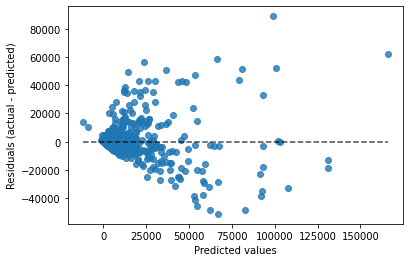

In [34]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred)
display.plot()
plt.show()

In [36]:
coef = reg["regressor"].coef_
model_features=reg.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)

Text(0.5, 1.0, 'Regression linéaire')

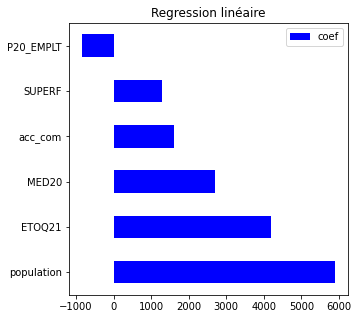

In [37]:
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(5, 5), color= 'blue')
)
plt.title("Regression linéaire")

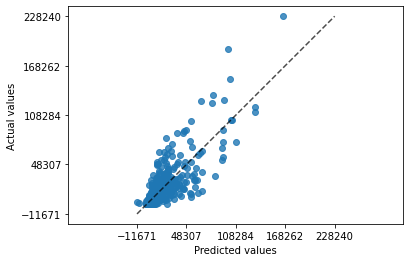

In [38]:
PredictionErrorDisplay.from_predictions( y_true= y_train, y_pred= reg.predict(X_train), 
                                        kind="actual_vs_predicted")

Cette représentation graphique met en évidence les valeurs prédites par le modèle ainsi que la droite de régression. Elle offre ainsi une illustration visuelle des écarts entre les prédictions du modèle et les valeurs réelles, permettant une interprétation visuelle des erreurs obtenues.

#### Amélioration du modèle

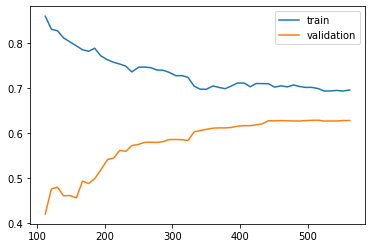

In [39]:
 # la courbe d'apprentissage 
k,train_score, val_score= learning_curve(reg,X_train, y_train,train_sizes= np.linspace(0.2,1), cv=5)
plt.plot(k, train_score.mean(axis=1), label="train")
plt.plot(k, val_score.mean(axis=1),label="validation")
plt.legend()



La courbe d'apprentissage est un outil utilisé pour déterminer la meilleure taille de l'ensemble d'entraînement afin d'éviter le sous-apprentissage et le surapprentissage du modèleSur la figure, nous pouvons observerr que les performances du modèle sont optimales pour des valeurs de taille d'ensemble d'entraînement et de test comprises entre 400 et 500, ce qui correspond à des proportions de partitionnement entre 0.4 et 0.5. Cela suggère que le modèle fournit les meilleures estimations lorsqu'il est entraîné sur des ensembles de données de cette taille spécifique, évitant ainsi les problèmes de sous-apprentissage ou de surapprentissage.

#### Régréssion sur les données transformées

In [40]:

def model_trans(estimateur,normaliseur):
    model_trans = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("Transformateur",TransformedTargetRegressor(
            regressor=estimateur, func=np.log1p, inverse_func=np.expm1
        ) )]
    )

    return model_trans

In [41]:
reg_trans= model_trans(LinearRegression(),RobustScaler())
reg_trans

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('Transformateur',
                 TransformedTargetRegressor(check_inverse=True,
                                            func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression(copy_X=True,
                                                                       fit_intercept=True,
                                                                       n_jobs=None,
                                                                       positive=False),
                                            transformer=None))],
         verbose=False)

In [42]:
reg_trans.fit(X_train, y_train)
y_test_predt = reg_trans.predict(X_test)
y_train_predt = reg_trans.predict(X_train)

In [43]:
print(f"Model score - training data: {reg_trans.score(X_train, y_train)}")
print(f"Model score - test data: {reg_trans.score(X_test, y_test)}")

Model score - training data: -17.063230169195503
Model score - test data: -928.3429305710802


Le modèle estimé sur une transformation logarithmique de la variable d'intérêt est inappropriéb pour ce travail.

#### Régression Lasso

La régression lasso fait partie du groupe des modèles linéaires qui intègre un facteur de pénalisation. Le choix optimal de ce fateur permet de construire un modèle consistant.
(Pour une meilleur compréhensiosn, vous pouver vous reférer à sklearn.linear_model.LinearRegression.)

Evaluons le modèle pour une valeur valeur spécifique alpha= 0.5

In [45]:
reg_lasso= model(Lasso(alpha=0.5),RobustScaler())
reg_lasso

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 Lasso(alpha=0.5, copy_X=True, fit_intercept=True,
                       max_iter=1000, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

In [46]:
reg_lasso.fit(X_train, y_train)
y_test_predl = reg_lasso.predict(X_test)
y_train_predl = reg_lasso.predict(X_train)

In [47]:
get_all_performances(value_train=(y_train, y_train_predl),
                     values_test=(y_test, y_test_predl),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,6.930850e-01,6.846661e-01
1,mean_squared_error,1.638640e+08,2.183848e+08
2,median_absolute_error,3.433837e+03,3.582924e+03
3,max_error,8.885279e+04,7.291524e+04


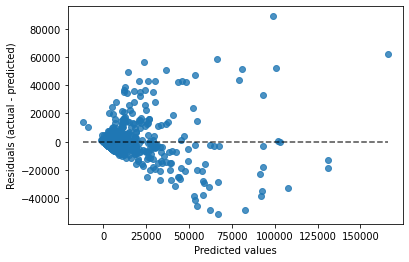

In [48]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_predl)
display.plot()
plt.show()

La regréssion lasso conduit au même résultat que la régréssion linéaire

Text(0.5, 1.0, 'Regression lasso')

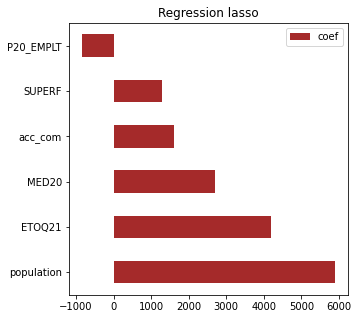

In [49]:
coef = reg_lasso["regressor"].coef_
model_features=reg_lasso.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(5, 5), color= 'brown')
)
plt.title("Regression lasso")

#### Amélioration du modèle

In [50]:
param_grid = {
    'regressor__alpha': [0.25, 0.5, 0.75,1],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [100, 500, 1000],
}

grid = GridSearchCV(reg_lasso, param_grid, cv=5, scoring="r2", return_train_score=True) 
grid

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('normaliseur',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     unit_variance=False,
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('regressor',
                                        Lasso(alpha=0.5, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              positive=False, precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__alpha': [0.25, 0.5, 0.75, 1],
                         'regressor__fit_intercept': [True, False],
                         'regressor__max_iter': [100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [51]:
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")

/home/cathu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+08, tolerance: 4.547e+07
  model = cd_fast.enet_coordinate_descent(


Best params: {'regressor__alpha': 1, 'regressor__fit_intercept': True, 'regressor__max_iter': 100}


GridSearchCV est une méthode essentielle pour déterminer de manière optimale les paramètres d'un modèle. Dans notre contexte spécifique, les résultats de la recherche indiquent un paramètre alpha égal à 1, ce qui suggère l'utilisation d'un modèle incluant une interception.

#### Réestimation du modèle

In [52]:
reg_lasso_r= model(Lasso(alpha=0.5),RobustScaler())
reg_lasso_r.fit(X_train, y_train)
y_test_predlr = reg_lasso_r.predict(X_test)
y_train_predlr = reg_lasso_r.predict(X_train)

In [53]:
get_all_performances(value_train=(y_train, y_train_predlr),
                     values_test=(y_test, y_test_predlr),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,6.930850e-01,6.846661e-01
1,mean_squared_error,1.638640e+08,2.183848e+08
2,median_absolute_error,3.433837e+03,3.582924e+03
3,max_error,8.885279e+04,7.291524e+04


#### Regréssion Ridge

In [54]:
reg_ridge= model(RidgeCV(),RobustScaler())
reg_ridge

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 RidgeCV(alpha_per_target=False, alphas=(0.1, 1.0, 10.0),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         scoring=None, store_cv_values=False))],
         verbose=False)

In [55]:
reg_ridge.fit(X_train, y_train)
y_test_predr = reg_ridge.predict(X_test)
y_train_predr = reg_ridge.predict(X_train)

In [56]:
get_all_performances(value_train=(y_train, y_train_predr),
                     values_test=(y_test, y_test_predr),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,6.930566e-01,6.849237e-01
1,mean_squared_error,1.638791e+08,2.182064e+08
2,median_absolute_error,3.452200e+03,3.578352e+03
3,max_error,8.930537e+04,7.284989e+04


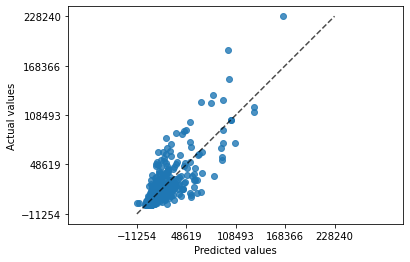

In [57]:
PredictionErrorDisplay.from_predictions( y_true= y_train, y_pred= reg_ridge.predict(X_train), 
                                        kind="actual_vs_predicted")

cette figure présente les valeurs prédites et la droite de regréssion. Elle fournit ainsi une explication visuelle aux erreur obtenues 

Text(0.5, 1.0, 'Regression Ridge')

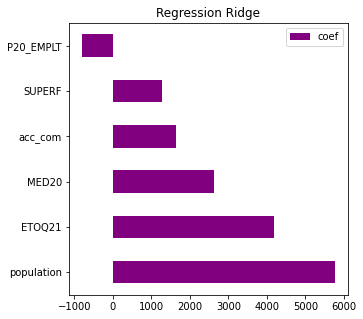

In [58]:
coef = reg_ridge["regressor"].coef_
model_features=reg_ridge.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(5, 5), color= 'purple')
)
plt.title("Regression Ridge")

In [59]:
reg_ridge.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 RidgeCV(alpha_per_target=False, alphas=(0.1, 1.0, 10.0),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         scoring=None, store_cv_values=False))],
         verbose=False)>

In [60]:
param_grid = {
    'regressor__alphas': [0.25, 0.5, 0.75,1],
    'regressor__fit_intercept': [True, False],
}

grid = GridSearchCV(reg_ridge, param_grid, cv=5, scoring="r2", return_train_score=True) 
grid

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('normaliseur',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     unit_variance=False,
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('regressor',
                                        RidgeCV(alpha_per_target=False,
                                                alphas=(0.1, 1.0, 10.0),
                                                cv=None, fit_intercept=True,
                                                gcv_mode=None, scoring=None,
                                                store_cv_values=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__alphas': [0.25, 0.5, 0.75, 1],
                         'regressor__fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [61]:
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__alphas': 1, 'regressor__fit_intercept': True}


### Modélisation linéaire de la longueur pondére

##### longueur_pond_hw

In [62]:
Y2= base['longueur_pond_hw']

In [68]:
reg_lin2=sm.OLS(Y2, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population', 'acc_com']])).fit()

In [69]:
print(reg_lin2.summary())

                            OLS Regression Results                            
Dep. Variable:       longueur_pond_hw   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     350.3
Date:                Sat, 30 Dec 2023   Prob (F-statistic):          1.42e-241
Time:                        23:53:14   Log-Likelihood:                -10977.
No. Observations:                1005   AIC:                         2.197e+04
Df Residuals:                     998   BIC:                         2.200e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9838.5886   2453.178     -4.011      0.0

In [70]:
# Normalité des résidus 
residus2= reg_lin2.resid
sw_test = shapiro(residus2)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.774201512336731, pvalue=4.903820344407395e-35)


In [71]:
# Autocorrélation des résidus
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
from scipy.stats import norm
dw_statistic= durbin_watson(residus2)
p_value = 2 * (1 - norm.cdf(dw_statistic))
print(f"P-value : {p_value}")

print(f"Statistique de Durbin-Watson : {dw_statistic}")

P-value : 0.043172012975140284
Statistique de Durbin-Watson : 2.022042000993579


In [73]:
#Hétéroscédasticité
bp_test = het_breuschpagan(residus2, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population', 'acc_com']]))
bp_test[1]

3.1110825599219824e-72

#### longueur_pond_adg

In [74]:
Y3= base['longueur_pond_adg']

In [75]:
reg_lin3=sm.OLS(Y3, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population', 'acc_com']])).fit()

In [76]:
print(reg_lin3.summary())

                            OLS Regression Results                            
Dep. Variable:      longueur_pond_adg   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     314.2
Date:                Sat, 30 Dec 2023   Prob (F-statistic):          6.89e-226
Time:                        23:53:47   Log-Likelihood:                -11008.
No. Observations:                1005   AIC:                         2.203e+04
Df Residuals:                     998   BIC:                         2.206e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8645.4704   2531.279     -3.415      0.0

In [77]:
# Normalité des résidus 
residus3= reg_lin3.resid
sw_test = shapiro(residus3)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.7693617343902588, pvalue=2.5565946022178936e-35)


In [78]:
# Autocorrélation des résidus
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
from scipy.stats import norm
dw_statistic= durbin_watson(residus3)
p_value = 2 * (1 - norm.cdf(dw_statistic))
print(f"P-value : {p_value}")

print(f"Statistique de Durbin-Watson : {dw_statistic}")

P-value : 0.04098951447999011
Statistique de Durbin-Watson : 2.0436360565631673


In [79]:
#Hétéroscédasticité
bp_test = het_breuschpagan(residus3, sm.add_constant(base[['SUPERF','MED20', 'P20_EMPLT', 'ETOQ21','population']]))
bp_test[1]

2.3163664498577e-59

Les estimations des longueurs pondérées convergent vers des résultats similaires à ceux de l'estimation sur la longueur totale. Cette convergence peut être attribuée à une insuffisance de données et de variables explicatives. En effet, plusieurs variables retenues pour l'estimation présentent des valeurs non renseignées, qui ont été remplacées par zéro. 
Par ailleurs, des variables telles que le niveau d'urbanisation de la commune, la topographie, le nombre d'étudiants de la commune auraient probablement fourni une meilleure explication si elles avaient été disponibles.


Par conséquent, les modèles actuels ne permettent pas de déterminer les variables explicatives des aménagements cyclables en Île-de-France. L'absence d'informations cruciales dans certaines variables limite la capacité du modèle à fournir une compréhension complète des facteurs qui influencent la présence et la qualité des aménagements cyclables dans la région.